***NB*** A lot of code adopted from Dr. Kang and Dr. Kavianpour, and their resources for the CMP417 module, unless otherwise specified.

Import some of the libraries that will be used for this project. 

In [1]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, zero_one_loss, accuracy_score
from sklearn.model_selection import train_test_split
import time
import datetime
import matplotlib.pyplot as plt

Rather than working on two separate DataFrames, I'll concatenate them, and split using train_test_split

In [2]:
test_data = pd.read_csv("CMP417_testing dataset.csv", header=0)
train_data = pd.read_csv("CMP417_training dataset.csv", header=0)

df = pd.concat([train_data, test_data])
df.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label,attack_cat
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,0,Normal
1,2,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,16,21,0,0,0,16,21,0,1,Generic
2,3,0.000008,udp,dns,INT,2,0,114,0,125000.000300,...,15,29,0,0,0,15,29,0,1,Generic
3,4,0.000008,udp,dns,INT,2,0,114,0,125000.000300,...,27,51,0,0,0,51,51,0,1,Generic
4,5,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,0,Normal


**EDIT 19/04/2022:** Although it doesn't matter that much, the conversion of the excel files to CSVs isn't necessary - Pandas is perfectly capable of reading .xlsx files using ``read_excel``.
I didn't need to swap the last two columns, either - but it was easier for me to work with at the time of writing this notebook.

In [3]:
df['label'].value_counts()

1    110
0     70
Name: label, dtype: int64

Now we've looked at a little bit about how the data is structured, let's factorise it...

In [4]:
df["proto"], protocols = pd.factorize(df["proto"])
df["service"], services = pd.factorize(df["service"])
df["state"], state = pd.factorize(df["state"])
df["attack_cat"], attack_cats = pd.factorize(df["attack_cat"])
features = df.iloc[:, :df.shape[1]-1]
labels = df.iloc[:,df.shape[1]-1:]
labels = labels.values.ravel()
df.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label,attack_cat
0,1,0.121478,0,0,0,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,0,0
1,2,0.000009,1,1,1,2,0,114,0,111111.107200,...,16,21,0,0,0,16,21,0,1,1
2,3,0.000008,1,1,1,2,0,114,0,125000.000300,...,15,29,0,0,0,15,29,0,1,1
3,4,0.000008,1,1,1,2,0,114,0,125000.000300,...,27,51,0,0,0,51,51,0,1,1
4,5,0.649902,0,0,0,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,0,0


Nice and factorised. Now, let's look at the std data. The values are quite spread out.

In [5]:
df_std = df.describe()
print(type(df_std))
df_std

<class 'pandas.core.frame.DataFrame'>


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label,attack_cat
count,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,1.800000e+02,...,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000
mean,46.055556,2.749663,2.027778,0.666667,0.744444,15.911111,9.933333,7181.338889,3995.600000,9.670676e+04,...,3.477778,11.655556,0.005556,0.005556,0.138889,5.716667,12.127778,0.016667,0.611111,2.355556
std,26.993631,9.709032,3.640907,1.123641,0.694127,74.075402,37.716318,49772.492520,23662.552322,1.516102e+05,...,5.391340,16.506752,0.074536,0.074536,0.432789,7.867105,16.140110,0.128376,0.488858,2.681662
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,46.000000,0.000000,0.000000e+00,...,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,23.000000,0.000008,0.000000,0.000000,0.000000,2.000000,0.000000,168.000000,0.000000,3.158659e+01,...,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,45.500000,0.000011,1.000000,0.000000,1.000000,2.000000,0.000000,564.000000,0.000000,9.090909e+04,...,1.000000,4.000000,0.000000,0.000000,0.000000,2.000000,5.000000,0.000000,1.000000,1.000000
75%,68.000000,0.619339,1.000000,1.000000,1.000000,10.000000,8.000000,1064.000000,354.000000,1.250000e+05,...,2.000000,16.250000,0.000000,0.000000,0.000000,7.000000,17.000000,0.000000,1.000000,4.000000
max,100.000000,59.997478,16.000000,5.000000,3.000000,900.000000,402.000000,502758.000000,263718.000000,1.000000e+06,...,27.000000,63.000000,1.000000,1.000000,4.000000,51.000000,62.000000,1.000000,1.000000,9.000000


Now it's time to train the model. to showcase the computational cost of NB, I've also implemented a basic benchmark. I'm getting an average of 0.002196073532104492 seconds, but my machine is quite high-end (at least, it *was* high-end two years ago...) 

This is where I did my own research - we never covered NB in the lectures, so I thought it would be interesting to challenge myself to design a model using NB, *intead* of using RF, as we covered more in-depth.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df, labels, train_size=0.8, random_state=7)
start_time = time.time()
print(f'Starting Gaussian NB: {datetime.datetime.fromtimestamp(start_time).strftime("%d/%m/%Y %H:%M:%S")}')

nb = GaussianNB()
nb.fit(X_train, y_train)
stop_time = time.time()
print(f'Finished training in: {stop_time - start_time}')

y_pred = nb.predict(X_test)
y_probabilities = nb.predict_proba(X_test)

Starting Gaussian NB: 03/04/2022 20:32:47
Finished training in: 0.0029578208923339844


In [8]:
from sklearn.metrics import confusion_matrix, zero_one_loss, roc_curve, auc, precision_recall_curve

results = confusion_matrix(y_test, y_pred)
error = zero_one_loss(y_test, y_pred)
print(f'Error: {error}')

Error: 0.8888888888888888


The error should be quite high, and the accuracy score very low...

In [9]:
print(accuracy_score(y_test, y_pred))

0.1111111111111111


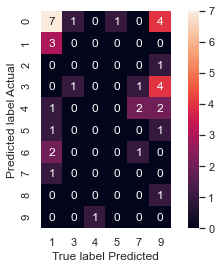

In [10]:
import seaborn as sns
sns.set()

cd = pd.crosstab(y_test, y_pred, rownames=["Actual"], colnames=["Predicted"])
sns.heatmap(cd, square=True, annot=True, fmt='d', cbar='True')
plt.xlabel('True label Predicted')
plt.ylabel('Predicted label Actual')
plt.show()

This has room for optimisation... because the features are indepdent and spread out, I could **scale** the data and see if I get a better result.

In [11]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

And now I'll do the prediction and benchmark again, using this scaled data... (I could've written this in a function, but I'm still getting the hang of using Jupyter Notebooks)

Starting Gaussian NB seeding at: 03/04/2022 20:32:59


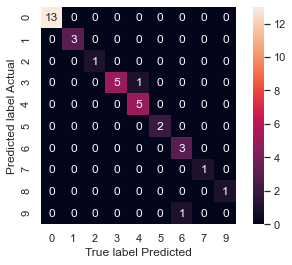

In [13]:
start_time = time.time()
print(f'Starting Gaussian NB seeding at: {datetime.datetime.fromtimestamp(start_time).strftime("%d/%m/%Y %H:%M:%S")}')

nb = GaussianNB()
nb.fit(X_train, y_train)
stop_time = time.time()

y_pred = nb.predict(X_test)
y_probabilities = nb.predict_proba(X_test)
results = confusion_matrix(y_test, y_pred)
error = zero_one_loss(y_test, y_pred)
cd = pd.crosstab(y_test, y_pred, rownames=["Actual"], colnames=["Predicted"])
sns.heatmap(cd, square=True, annot=True, fmt='d', cbar='True')
plt.xlabel('True label Predicted')
plt.ylabel('Predicted label Actual')
plt.show()

In [15]:
print(f'''
Starting Gaussian NB seeding at: {datetime.datetime.fromtimestamp(start_time).strftime("%d/%m/%Y %H:%M:%S")}\n
Finished training in: {stop_time - start_time}\n
Error: {error}\n
Accuracy: {accuracy_score(y_test, y_pred)}\n
''')


Starting Gaussian NB seeding at: 03/04/2022 20:32:59

Finished training in: 0.0019996166229248047

Error: 0.08333333333333337

Accuracy: 0.9166666666666666




Now, to implement the AUROC and Preceision Recall curves.

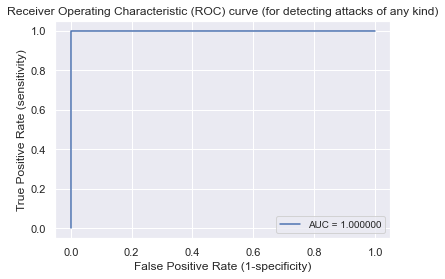

In [16]:
# Plot Receiver Operating Characteristic (ROC) and Precision-Recall Curves
# Convert classification output to 0 for normal and 1 for attacks of any kind
y_test_binary = []
y_score = []
for n in range(len(y_test)):
    l = y_test[n]
    y_score.append(sum(y_probabilities[n,:])-y_probabilities[n,0]) #sum probabilities of all attack categories excluding normal
    if attack_cats[l] == 'Normal':
        assert (l == 0) #check that the label for normal is 0
        y_test_binary.append(0)
    else:
        y_test_binary.append(1)
y_test_binary = np.array(y_test_binary)
y_score = np.array(y_score)

fpr, tpr, thresholds = roc_curve(y_test_binary, y_score, pos_label=1)
roc_auc = auc(fpr, tpr)
precision, recall, thresholds_precision_recall = precision_recall_curve(y_test_binary, y_score, pos_label=1)
auc_pr = auc(recall, precision)

plt.figure()
plt.plot(fpr, tpr, label='AUC = %0.6f' % (roc_auc))
plt.xlabel('False Positive Rate (1-specificity)')
plt.ylabel('True Positive Rate (sensitivity)')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.title('Receiver Operating Characteristic (ROC) curve (for detecting attacks of any kind)')
plt.legend(loc="lower right", prop={'size': 'small'})
plt.savefig('ROC curve for neural network.png')
plt.savefig('ROC curve for neural network.pdf')
plt.show()

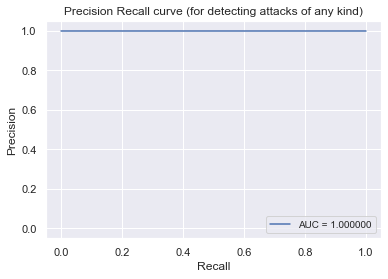

In [17]:
plt.figure()
plt.plot(recall, precision, label='AUC = %0.6f' % (auc_pr))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.title('Precision Recall curve (for detecting attacks of any kind)')
plt.legend(loc="lower right", prop={'size': 'small'})
plt.savefig('Precision Recall curve for neural network.png')
plt.savefig('Precision Recall curve for neural network.pdf')
plt.show()